Goal : confirm if the DM connection to the Multinomial logistic normal holds

Two MC models
1. Sample from DM and evaluate ratio of LN to Dir for each sample
2. Sample from LN and evaluate MLN

In [1]:
import numpy as np
from scipy.stats import multinomial, dirichlet, multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
from skbio.stats.composition import ilr_inv, ilr, closure
%matplotlib inline

In [2]:
from scipy.stats._multivariate import _PSD

_LOG_2PI = np.log(2 * np.pi)

def sample_dirichlet_multinomial(alpha, n, samples=10):
    dir_ = dirichlet(alpha)
    dx = dir_.rvs(samples)
    mx = np.vstack([np.random.multinomial(n[i], dx[i]) for i in range(dx.shape[0])])
    return mx

def sample_dirichlet(alpha, samples=10):
    dir_ = dirichlet(alpha)
    dx = dir_.rvs(samples)
    return dx

def sample_logistic_normal(mean, cov, samples=10):
    mvn_ = multivariate_normal(mean, cov)
    mx = mvn_.rvs(samples)
    return ilr_inv(mx)

def multinomial_logpdf(x, n, p):
    return np.vstack([multinomial(n[i], p[i]).logpmf(x[i]) for i in range(x.shape[0])])

def multinomial_likelihood(x, n, p):
    return np.mean(multinomial_logpdf(x, n, p))

def logistic_normal_likelihood(x, mean, cov):
    mvn_ = multivariate_normal(mean, cov)
    y = ilr(x)
    return np.mean(mvn_.logpdf(y))

def dirichlet_likelihood(x, alpha):
    dir_ = dirichlet(alpha)
    y = closure(x)
    return np.mean([dir_.logpdf(y[i]) for i in range(y.shape[0])])

def dirichlet_likelihood2(x, alpha):
    y = closure(x)
    return np.mean([dirichlet(alpha[i]).logpdf(y[i]) for i in range(y.shape[0])])

def sample_multinomial(n, p):
    return np.vstack([np.random.multinomial(n[i], p[i]) for i in range(p.shape[0])])

def logit_normal_logpdf(x, mean, cov):
    y = ilr(x)
    diff = y - mean
    prec = np.linalg.inv(cov)
    psd = _PSD(cov, allow_singular=False)
    prec_U = psd.U
    log_det_cov = psd.log_pdet
    maha = np.sum(np.square(np.dot(diff, prec_U)), axis=-1)
    logx = np.log(x).sum()
    d = prec_U.shape[0]
    logp = (-0.5) * (_LOG_2PI + log_det_cov + maha) - logx
    return logp

def logit_normal_likelihood(x, mean, cov):
    return np.mean([logit_normal_logpdf(x[i], mean, cov) for i in range(x.shape[0])])
    
def logit_div_dir_logpdf(x, alpha, mean, cov):
    mvn_ = multivariate_normal(mean, cov)
    dir_ = dirichlet(alpha)
    #logln = np.vstack([logit_normal_logpdf(x[i], mean, cov) for i in range(x.shape[0])])
    logln = np.vstack([mvn_.logpdf(ilr(x[i])) for i in range(x.shape[0])])
    y = closure(x)
    logdir = np.vstack([dir_.logpdf(y[i]) for i in range(y.shape[0])])
    return logln - logdir    


def logit_div_dir_logpdf2(x, eta, alpha, mean, cov):
    mvn_ = multivariate_normal(mean, cov)
    #logln = np.vstack([logit_normal_logpdf(x[i], mean, cov) for i in range(x.shape[0])])
    logln = np.vstack([mvn_.logpdf(ilr(eta[i])) for i in range(x.shape[0])])
    y = closure(x)
    e = closure(eta)
    logdir = np.vstack([dirichlet(e[i]).logpdf(y[i]) for i in range(y.shape[0])])
    return logln - logdir    


In [3]:
d = 5
n = 1000
mean = np.ones(d - 1)
cov = np.diag(np.ones(d - 1))
alpha = np.ones(d)
N = np.ones(n) * 1000000

Estimate mean of of multinomial logistic normal

In [4]:
p = sample_logistic_normal(mean, cov, samples=n)
x = sample_multinomial(N, p)
multinomial_logpdf(x, N, p).mean()

-27.440905723592266

Compute difference likelihood distribution

Then look at samples from dirichlet multinomial

In [5]:
eta = sample_dirichlet_multinomial(alpha, N, samples=n) 
#peta = logit_div_dir_logpdf2(x, eta, alpha, mean, cov)

In [6]:
np.mean(logit_div_dir_logpdf2(x, eta, alpha, mean, cov))

-8.262565720412672

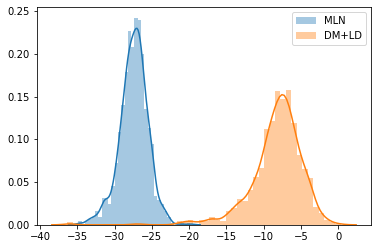

In [7]:
sns.distplot(multinomial_logpdf(x, N, p), label='MLN')
sns.distplot(logit_div_dir_logpdf2(x, eta, alpha, mean, cov), label='DM+LD')
plt.legend()